# Final Project: Apple Disease Classification
**Based on the Kaggle competition: [Apple Disease Classification](https://www.kaggle.com/c/plant-pathology-2020-fgvc7/overview)**

### Setting up Env

In [3]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
  colab_flag = True
else:
  colab_flag = False

if colab_flag == True:
   print("Running in Colab...")
   #Install Kaggle API
   ! pip install -q kaggle
   #Install Huggingface Datasets lib
   ! pip install -q datasets
   #Install Huggingface transformers
   ! pip install -q transformers[torch]
   #Intall Timm for Pytorch Image Models
   ! pip install -q timm
   print("...Installed required dependencies")
else:
   print("Running in local environment...")

Running in local environment...


In [4]:
if colab_flag == True:
  import json
  from google.colab import drive
  drive.mount('/content/drive/')

  # Set the file path
  file_path = '/content/drive/MyDrive/dtu/fastAI/04_NLP/kaggle_api.json'

  # Check if the file exists
  if os.path.exists(file_path):
      # Load the JSON file
      with open(file_path) as f:
          creds = json.load(f)
      print('Sucesfully set kaggle credentials')
  else:
      # Handle the case when the file does not exist
      creds = None  # or any other appropriate action you want to take
      print('Error: File not found, Credentials NOT set')
else:
    import json
    file_path = "../secrets/kaggle_api.json"
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the JSON file
        with open(file_path) as f:
            creds = json.load(f)
        print('Sucesfully set kaggle credentials')
    else:
        # Handle the case when the file does not exist
        creds = None  # or any other appropriate action you want to take
        print('Error: File not found, Credentials NOT set')

Sucesfully set kaggle credentials


### Downloading the data

In [21]:
#using `pathlib.Path to work with paths in Python`
from pathlib import Path
#Set path for the titanic dataset
path = Path('plant-pathology-2020-fgvc7')

if path.exists():
  print('Data folder exists')
else:
  print('Data not detected, starting download')
  #Setup of kaggle credentials to use the API for downloading dataset
  cred_path = Path('~/.kaggle/kaggle.json').expanduser()
  if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(json.dumps(creds))
    #If not Json
    #cred_path.write_text(creds)
    cred_path.chmod(0o600)
  import zipfile,kaggle
  #Download data
  kaggle.api.competition_download_cli(str(path))
  #Unzip at path
  zipfile.ZipFile(f'{path}.zip').extractall(path)

#Verifying the the local content
!ls {path}

Data not detected, starting download
plant-pathology-2020-fgvc7.zip: Skipping, found more recently modified local copy (use --force to force download)
images	sample_submission.csv  test.csv  train.csv


In [22]:
#Move all images from the images folder starting with Test_ to a new subfolder called test ditto for train

import os
import shutil

# Create a new folder called test unless it already exists
if not os.path.exists('test'):
    os.mkdir('plant-pathology-2020-fgvc7/test')
    os.mkdir('plant-pathology-2020-fgvc7/train')
 
# Move all images from the images folder starting with Test_ to a new subfolder called test within plant-pathology-2020-fgvc7
for file_name in os.listdir('plant-pathology-2020-fgvc7/images'):
    if file_name.startswith('Test_'):
        shutil.move(f'{path}/images/{file_name}', 'plant-pathology-2020-fgvc7/test')
    elif file_name.startswith('Train_'):
        shutil.move(f'{path}/images/{file_name}', 'plant-pathology-2020-fgvc7/train')
        

In [16]:
import timm
from fastai.vision.all import *
set_seed(42)

train_path = path/'train'
train_files = get_image_files(train_path)

test_path = path/'test'
test_files = get_image_files(train_path)

In [17]:
#Simply contains the filename of all the images in the given folder
train_files[0:3]

(#3) [Path('plant-pathology-2020-fgvc7/train/Train_719.jpg'),Path('plant-pathology-2020-fgvc7/train/Train_544.jpg'),Path('plant-pathology-2020-fgvc7/train/Train_758.jpg')]

Shape of image to PIL image: (1365, 2048)
Shape according to torch, tensor: torch.Size([1365, 2048, 3])


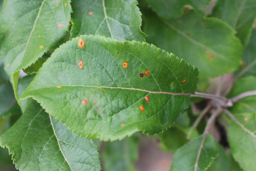

In [20]:
img = PILImage.create(train_files[5])
print(f'Shape of image to PIL image: {img.shape}')
#Convert to tensor
img_t = tensor(img)
print(f'Shape according to torch, tensor: {img_t.shape}')
img.to_thumb(256)